In [26]:
import matplotlib.pyplot as plt
import scipy.optimize as spo
import jax.numpy as np
jnp = np
import jax

from my_timer import timer_decorator

# Definice funkcí s jax knihovnou pro možnost automatické derivace (np je nyní z jax.numpy)

In [27]:
def energy_jax(v_internal, fx, v, h, p):
    v = v.at[1:-1].set(v_internal)
    vx = (v[1:] - v[:-1]) / h
    v_mid = (v[1:] + v[:-1]) / 2
    Jv_density = (1 / p) * np.abs(vx)**p - fx * v_mid

    return np.sum(h * Jv_density)


# exact minimizer for p=2
def u_init(x):
    return 0 * (x + 1) * (x - 1)


# rhs
def f(x):
    return -10 * np.ones(x.size)


# úloha stejně jako v pLaPlace_numba

In [28]:
p, a, b = 13, -1, 1
ne = 1000
x = np.linspace(a, b, ne + 1)
h = np.diff(x)

v = u_init(x)            # testing function
v_internal = v[1:-1].copy()
x0 = v_internal.copy()   # initial guess


x_mid = (x[1:] + x[:-1]) / 2
fx = f(x_mid)

# Definování funkce, gradientu a hesiánu; nastavení automatické kompilace jit; vyrobení funce s jedním vstupem

In [29]:
# automatická derivace a kompilace
fun = jax.jit(energy_jax)
dfun = jax.jit(jax.grad(energy_jax, argnums=0))
fun1 = lambda v_internal: fun(v_internal, fx, v, h, p)
dfun1 = lambda v_internal: dfun(v_internal, fx, v, h, p)

# V následujících třech buňkách se s prvním zavoláním funkce rovnou kompiluje jit 

In [30]:
print(f"Initial energy: {fun1(v_internal)}")
print(f"||g||={np.linalg.norm(dfun1(v_internal))}")

Initial energy: 0.0
||g||=0.632139265537262


# solution using laplace approximation of hessian and line search using golden section search

In [31]:
import numpy
def zlatyrez(f, a, b, x, ddd, tol):
    gamma = 1/2 + numpy.sqrt(5)/2
    a0 = a
    b0 = b
    d0 = (b0-a0)/gamma + a0
    c0 = a0 + b0 - d0
    it = 0
    an = a0
    bn = b0
    cn = c0
    dn = d0
    fcn = f(x + cn * ddd)
    fdn = f(x + dn * ddd)

    while bn - an > tol:
        a = an
        b = bn
        c = cn
        d = dn
        fc = fcn
        fd = fdn

        if fc < fd:
            an = a
            bn = d
            dn = c
            cn = an + bn - dn
            fcn = f(x + cn * ddd)
            fdn = fc
        else:
            an = c
            bn = b
            cn = d
            dn = an + bn - cn
            fcn = fd
            fdn = f(x + dn * ddd)

        it += 1

    t = (an + bn) / 2
    return t, it


In [32]:
import numpy
@timer_decorator
def gradient_line_search(f, df, hess_approx_sol, x0, tolf=1e-6, tolg=1e-3, maxit=1000, verbose=False):
    """
    Trust Region (quasi-Newton method)

    Parameters
    ----------
    f : function
        The objective function to be minimized.
    df : function
        The gradient of the objective function.
    hess_approx_sol : function
        Apply the inverse of the approximate Hessian to a vector.
    x0 : numpy.ndarray
        The initial guess for the minimum.
    tolf : float
        The tolerance for the stopping condition for f.
    tolg : float
        The tolerance for the stopping condition for g.
    maxit : int
        The maximum number of iterations.
    verbose : bool
        If True, print the iteration number, the value of f, the size of the
        trust region, and the norm of the gradient.

    Returns
    -------
    xmin : numpy.ndarray
        The found minimum.
    it : int
        The number of iterations.
    """

    x = x0
    it = maxit
    fx = f(x)
    fx_old = -np.inf
    dfx = df(x)
    t0 = 1
    norm_dfx = np.linalg.norm(dfx)
    norm_fx = np.abs(fx - fx_old)
    for i in range(maxit):
        if norm_dfx < tolg:
            it = i
            break
        if norm_fx < tolf:
            it = i
            break
        dfx_laplace = -hess_approx_sol(numpy.array(dfx))
        t, zit = zlatyrez(f,0,t0,x,dfx_laplace,1e-9)
        t0 = t*2
        x = x + t * dfx_laplace
        fx_old = fx
        fx = f(x)
        dfx = df(x)
        norm_dfx = np.linalg.norm(dfx)
        norm_fx = np.abs(fx - fx_old)
        if verbose:
            print(f"it={i}, f={fx}, ||g||={norm_dfx}, , |f - fold|={norm_fx} ,t={t},zit={zit}")

    
    print(f"it={it}, f={fx}, ||g||={norm_dfx}, , |f - fold|={norm_fx}")
    return x, it

In [33]:
import numpy as np
from scipy.sparse import diags
def laplace_1D(x):
    # Calculate distances between nodes
    h = np.diff(x)

    # Initialize diagonals
    main_diag = np.hstack((1, 1/h[:-1] + 1/h[1:], 1))
    lower_diag = np.hstack((0, -1/h[1:]))
    upper_diag = np.hstack((-1/h[:-1], 0))

    # Create the sparse matrix
    laplace_matrix = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1]).tocsc()


    return laplace_matrix[1:-1,1:-1]

In [34]:
from scipy.sparse.linalg import factorized
A = laplace_1D(x)
hess_approx_sol = factorized(A)

In [35]:
resx, it = gradient_line_search(fun1, dfun1, hess_approx_sol, x0, tolf=1e-8, tolg=1e-3, maxit=10000, verbose=True)

it=0, f=-8.475288391113281, ||g||=7.073992729187012, , |f - fold|=8.475288391113281 ,t=0.13765978035143073,zit=41
it=1, f=-8.895559310913086, ||g||=2.0851635932922363, , |f - fold|=0.4202709197998047 ,t=0.013372597029348024,zit=41
it=2, f=-9.527647018432617, ||g||=4.6157121658325195, , |f - fold|=0.6320877075195312 ,t=0.02674518687295281,zit=36
it=3, f=-9.799003601074219, ||g||=7.259303569793701, , |f - fold|=0.27135658264160156 ,t=0.02962967552698751,zit=38
it=4, f=-10.057997703552246, ||g||=7.138062477111816, , |f - fold|=0.25899410247802734 ,t=0.023967823761967464,zit=38
it=5, f=-10.183317184448242, ||g||=8.498204231262207, , |f - fold|=0.1253194808959961 ,t=0.024403675902697312,zit=37
it=6, f=-10.288409233093262, ||g||=7.343560218811035, , |f - fold|=0.10509204864501953 ,t=0.02144270634429135,zit=37
it=7, f=-10.356362342834473, ||g||=7.397701740264893, , |f - fold|=0.06795310974121094 ,t=0.022590021515878536,zit=37
it=8, f=-10.414043426513672, ||g||=6.569295406341553, , |f - fold|=

it=69, f=-10.727224349975586, ||g||=0.8391430974006653, , |f - fold|=0.0002689361572265625 ,t=0.022741781209843544,zit=37
it=70, f=-10.727476119995117, ||g||=0.6556617021560669, , |f - fold|=0.00025177001953125 ,t=0.01779384819424502,zit=37
it=71, f=-10.727724075317383, ||g||=0.761295735836029, , |f - fold|=0.000247955322265625 ,t=0.02206805625755728,zit=37
it=72, f=-10.72795295715332, ||g||=0.6447429060935974, , |f - fold|=0.0002288818359375 ,t=0.018528532295068723,zit=37
it=73, f=-10.728179931640625, ||g||=0.771020770072937, , |f - fold|=0.0002269744873046875 ,t=0.02241565527619143,zit=37
it=74, f=-10.728392601013184, ||g||=0.6103454232215881, , |f - fold|=0.00021266937255859375 ,t=0.017855639071183097,zit=37
it=75, f=-10.72860336303711, ||g||=0.7266905307769775, , |f - fold|=0.00021076202392578125 ,t=0.022363534846424647,zit=37
it=76, f=-10.728799819946289, ||g||=0.6031318306922913, , |f - fold|=0.0001964569091796875 ,t=0.01828234933623843,zit=37
it=77, f=-10.72899341583252, ||g||=0

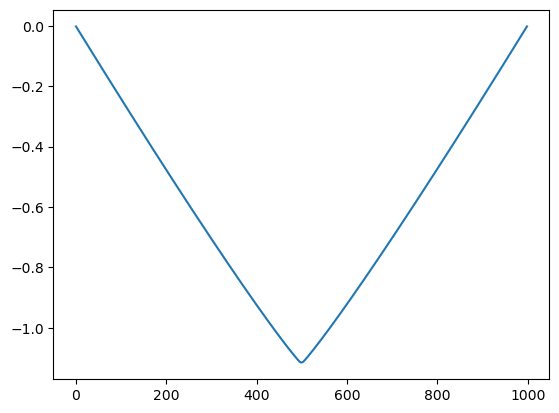

In [39]:
plt.plot(resx)

In [37]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [38]:
%lprun -f gradient_line_search.__wrapped__ -f zlatyrez gradient_line_search(fun1, dfun1, hess_approx_sol, x0, tolf=1e-5, tolg=1e-3, maxit=10000, verbose=False)

it=194, f=-10.735031127929688, ||g||=0.4077983498573303, , |f - fold|=9.5367431640625e-06
gradient_line_search#1: 1.232 s


Timer unit: 1e-09 s

Total time: 1.22936 s
File: /tmp/ipykernel_161410/2218177951.py
Function: gradient_line_search at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @timer_decorator
     3                                           def gradient_line_search(f, df, hess_approx_sol, x0, tolf=1e-6, tolg=1e-3, maxit=1000, verbose=False):
     4                                               """
     5                                               Trust Region (quasi-Newton method)
     6                                           
     7                                               Parameters
     8                                               ----------
     9                                               f : function
    10                                                   The objective function to be minimized.
    11                                               df : function
    12                                 